# 03 - Minimum Eigen Optimizer

In [1]:
# This code is from the tutorial at:
# https://qiskit-community.github.io/qiskit-optimization/tutorials/03_minimum_eigen_optimizer.html

In [2]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA

# Switch to Quantum Rings's Sampler
#from qiskit.primitives import Sampler
from quantumrings.toolkit.qiskit import QrSamplerV1 as Sampler

from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

In [3]:
# create a QUBO
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2})
print(qubo.prettyprint())

Problem name: 

Minimize
  x*y - x*z + 2*y*z + x - 2*y + 3*z

Subject to
  No constraints

  Binary variables (3)
    x y z



In [4]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 1.5
operator:
SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[-0.5 +0.j,  0.25+0.j, -1.75+0.j,  0.25+0.j, -0.25+0.j,  0.5 +0.j])


In [5]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
print(qp.prettyprint())

Problem name: 

Minimize
  x0*x1 - x0*x2 + 2*x1*x2 + x0 - 2*x1 + 3*x2

Subject to
  No constraints

  Binary variables (3)
    x0 x1 x2



In [6]:
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

In [7]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [8]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


In [9]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


In [10]:
print("variable order:", [var.name for var in qaoa_result.variables])
for s in qaoa_result.samples:
    print(s)

variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 0.]), fval=np.float64(-2.0), probability=0.1220703125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=np.float64(0.0), probability=0.1640625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=np.float64(0.0), probability=0.13671875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=np.float64(1.0), probability=0.076171875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=np.float64(3.0), probability=0.1552734375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=np.float64(3.0), probability=0.091796875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=np.float64(3.0), probability=0.146484375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=np.float

In [11]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [12]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 1., 0.]), fval=np.float64(-2.0), probability=0.1220703125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=np.float64(0.0), probability=0.1640625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=np.float64(0.0), probability=0.13671875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=np.float64(1.0), probability=0.076171875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=np.float64(3.0), probability=0.1552734375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=np.float64(3.0), probability=0.091796875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=np.float64(3.0), probability=0.146484375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=np.float64(4.0), probability=0.107421875

In [13]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [14]:
np.mean(fvals)

np.float64(1.5)

In [15]:
np.std(fvals)

np.float64(1.9364916731037085)

In [16]:
samples_for_plot = {
    " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 0.1220703125,
 'x=0 y=0 z=0': 0.1640625,
 'x=1 y=1 z=0': 0.13671875,
 'x=1 y=0 z=0': 0.076171875,
 'x=0 y=0 z=1': 0.1552734375,
 'x=1 y=0 z=1': 0.091796875,
 'x=0 y=1 z=1': 0.146484375,
 'x=1 y=1 z=1': 0.107421875}

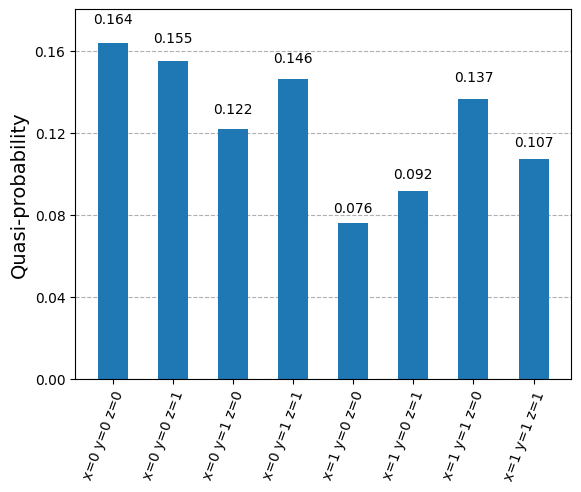

In [17]:
plot_histogram(samples_for_plot)

In [18]:
rqaoa = RecursiveMinimumEigenOptimizer(qaoa, min_num_vars=1, min_num_vars_optimizer=exact)

In [19]:
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


In [20]:
filtered_samples = get_filtered_samples(
    rqaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
)

In [21]:
samples_for_plot = {
    " ".join(f"{rqaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 1.0}

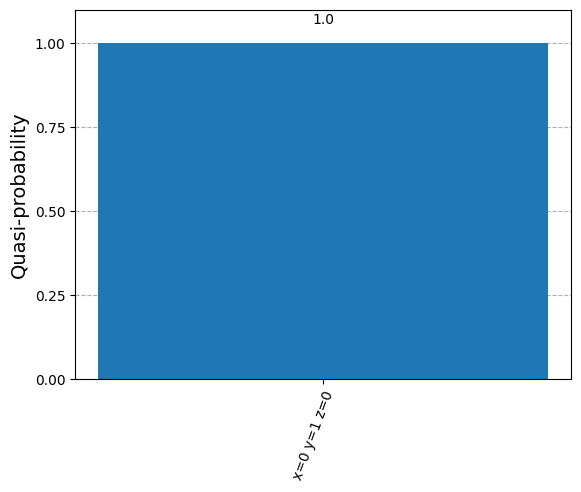

In [22]:
plot_histogram(samples_for_plot)